<a href="https://colab.research.google.com/github/jeroen-stam/Python-ML/blob/main/Energy_demand_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#importing pandas and importing csv

import pandas as pd

# Adjust the path as needed
path = '/content/drive/MyDrive/Data Energy Demand Forecast/electricity_nl_final.csv'



In [3]:
#Making sure ; is used as delimiter, also parcing the dateUTC variable for python to read it as a date and time
df = pd.read_csv(path, delimiter=';', parse_dates=['DateUTC'])
df['DateUTC'] = pd.to_datetime(df['DateUTC'], errors='coerce')  # ensure datetime
df.set_index('DateUTC', inplace=True)
df.sort_index(inplace=True)
df.head()

,load_mw
DateUTC,
2020-01-01 00:00:00,11184.23
2020-01-01 01:00:00,10984.06
2020-01-01 02:00:00,10686.04
2020-01-01 03:00:00,10489.32
2020-01-01 04:00:00,10579.91


In [4]:
#doing some checks on the Data
print(df.shape)
print(df.index.min(), df.index.max())
print(df['load_mw'].describe())

(60707, 1)
2020-01-01 00:00:00 2024-12-12 23:00:00
count    60707.000000
mean     12484.039643
std       1935.528034
min          9.000000
25%      10955.775000
50%      12269.430000
75%      13711.990000
max      20059.640000
Name: load_mw, dtype: float64


In [5]:
#resampling to daily use averages, since we want to forecast daily use values. Hourly data is noisy, and resampling makes training of model faster
df_daily = df.resample('D').mean().dropna()
df_daily.head()

,load_mw
DateUTC,
2020-01-01,12090.800000
2020-01-02,12705.684167
2020-01-03,11881.042917
2020-01-04,11992.527917
2020-01-05,11863.527917


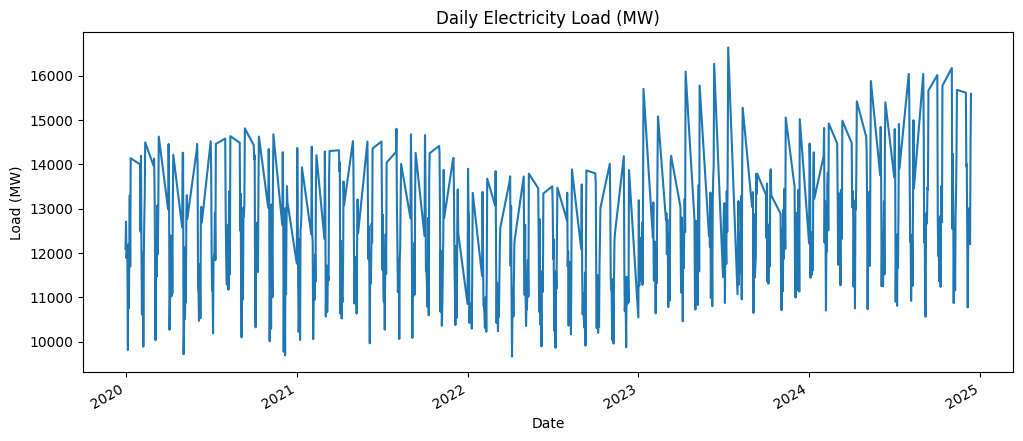

In [6]:
import matplotlib.pyplot as plt

df_daily['load_mw'].plot(figsize=(12, 5), title='Daily Electricity Load (MW)')
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.show()

In [7]:
#making a binary variable for holiday so the model handles this better
import holidays

nl_holidays = holidays.Netherlands(years=[2020, 2023, 2024])
# Convert the index to a Series before applying isin
df_daily['is_holiday'] = pd.Series(df_daily.index.date).isin(nl_holidays)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpzxh38zhm/e341t97f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzxh38zhm/ck3pqanx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25853', 'data', 'file=/tmp/tmpzxh38zhm/e341t97f.json', 'init=/tmp/tmpzxh38zhm/ck3pqanx.json', 'output', 'file=/tmp/tmpzxh38zhm/prophet_model9bnmrflr/prophet_model-20250514185457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzxh38zhm/ound3f0d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzxh38zhm/sbce54nd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

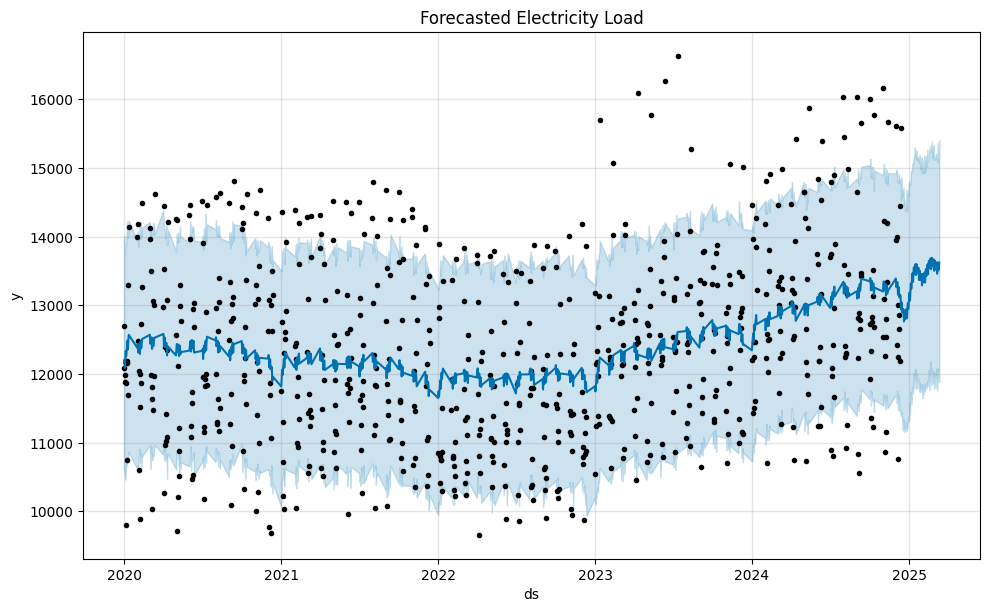

In [8]:
from prophet import Prophet
# Prophet expects two columns: ds (date), y (value)
df_prophet = df_daily.reset_index().rename(columns={'DateUTC': 'ds', 'load_mw': 'y'}) #Rename DateUTC to ds

# Fit model
model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(df_prophet)

# Create future dataframe (e.g., 90 days ahead)
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

# Plot forecast
from prophet import Prophet
# Prophet expects two columns: ds (date), y (value)
df_prophet = df_daily.reset_index().rename(columns={'DateUTC': 'ds', 'load_mw': 'y'}) #Rename DateUTC to ds

# Fit model
model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(df_prophet)

# Create future dataframe (e.g., 90 days ahead)
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.title("Forecasted Electricity Load")
plt.show()

In [9]:
#testing model performance

# Hold out last 90 days as test set
train = df_prophet[:-90]
test = df_prophet[-90:]

# Refit on training data
model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(train)

# Forecast the test period
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

# Compare predicted vs actual
from sklearn.metrics import mean_absolute_error

forecast_test = forecast[-90:][['ds', 'yhat']].set_index('ds')
actual_test = test.set_index('ds')

mae = mean_absolute_error(actual_test['y'], forecast_test['yhat'])
print(f"MAE: {mae:.2f} MW")

DEBUG:cmdstanpy:input tempfile: /tmp/tmpzxh38zhm/gnf4vejl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzxh38zhm/5x0a0sn2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91101', 'data', 'file=/tmp/tmpzxh38zhm/gnf4vejl.json', 'init=/tmp/tmpzxh38zhm/5x0a0sn2.json', 'output', 'file=/tmp/tmpzxh38zhm/prophet_models349isko/prophet_model-20250514185509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 1213.95 MW


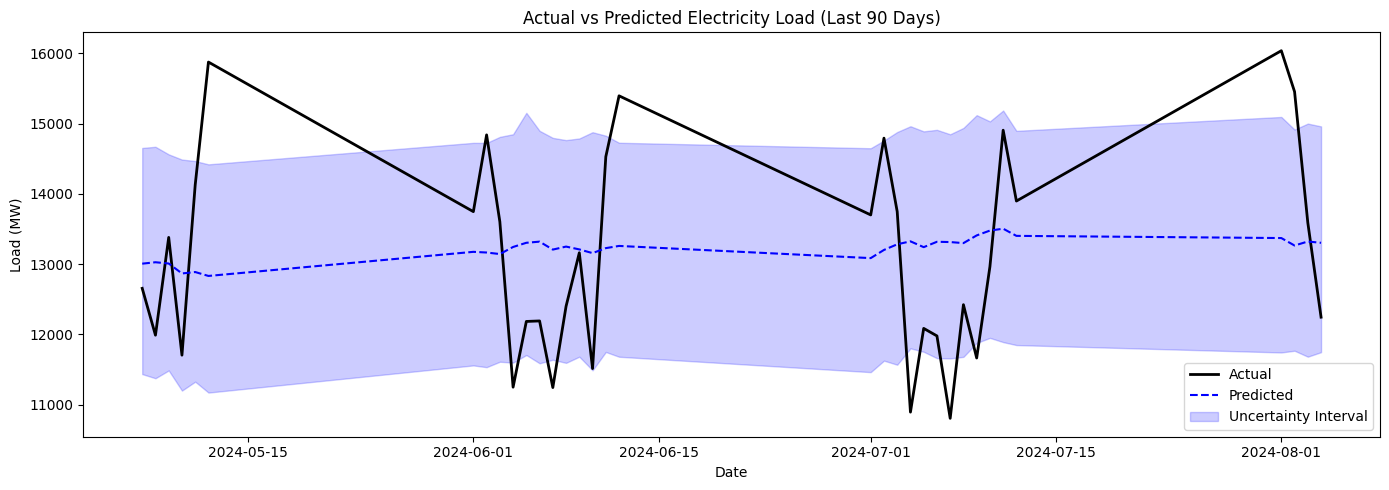

In [10]:
#plotting actual vs predicted

import matplotlib.pyplot as plt

# Reset index for both DataFrames
actual_test = test.set_index('ds')
forecast_test = forecast.set_index('ds')

# Get the common index values
common_index = actual_test.index.intersection(forecast_test.index)

# Filter both DataFrames using the common index
actual_test = actual_test.loc[common_index]
forecast_test = forecast_test.loc[common_index]

# Plot
plt.figure(figsize=(14, 5))
plt.plot(actual_test['y'], label='Actual', color='black', linewidth=2)
plt.plot(forecast_test['yhat'], label='Predicted', color='blue', linestyle='--')
# Filter uncertainty interval data using common index
forecast_test_filtered = forecast_test.loc[common_index]
plt.fill_between(forecast_test_filtered.index, forecast_test_filtered['yhat_lower'], forecast_test_filtered['yhat_upper'],
                 color='blue', alpha=0.2, label='Uncertainty Interval')
plt.title('Actual vs Predicted Electricity Load (Last 90 Days)')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.legend()
plt.tight_layout()
plt.show()